<a href="https://colab.research.google.com/github/dhruvohri07-web/sentimen-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset loaded successfully.
Dataset Columns: Index(['Text', 'label'], dtype='object')
Using column 'Text' for text analysis.
Lexicon-Based Sentiment Analysis Results:
                                                Text sentiment_vader  \
0  This is  the best apps acording to a bunch of ...        Positive   
1  This is a pretty good version of the game for ...        Positive   
2  this is a really . there are a bunch of levels...        Positive   
3  This is a silly game and can be frustrating, b...        Positive   
4  This is a terrific game on any pad. Hrs of fun...        Positive   

  sentiment_textblob  
0           Positive  
1           Positive  
2           Positive  
3           Negative  
4           Positive  
Logistic Regression Sentiment Analysis:
              precision    recall  f1-score   support

           0       0.74      0.48      0.58       643
           1       0.86      0.97      0.91      3163
           2       0.73      0.04      0.08       194

   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 67s 257ms/step - accuracy: 0.7944 - loss: 0.6305 - val_accuracy: 0.8465 - val_loss: 0.3909
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 257ms/step - accuracy: 0.8761 - loss: 0.3290 - val_accuracy: 0.8635 - val_loss: 0.3767
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - accuracy: 0.9181 - loss: 0.2395 - val_accuracy: 0.8648 - val_loss: 0.3863
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.9373 - loss: 0.1916 - val_accuracy: 0.8650 - val_loss: 0.4324
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - accuracy: 0.9497 - loss: 0.1530 - val_accuracy: 0.8547 - val_loss: 0.4473
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8475 - loss: 0.4568
LSTM Model Accuracy: 0.8547
Processed data saved to 'processed_amazon.csv'


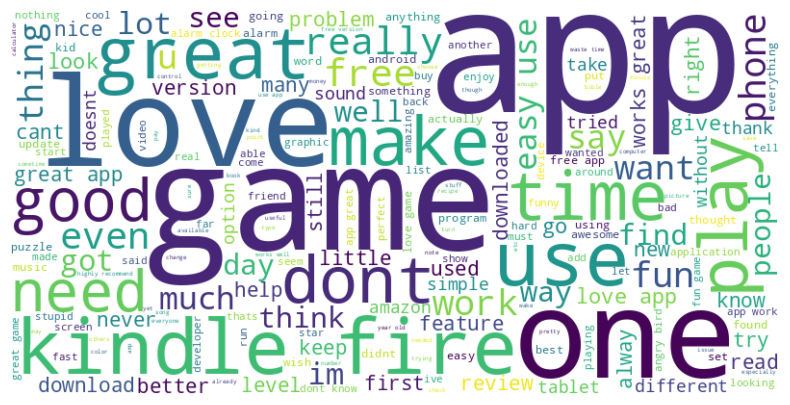

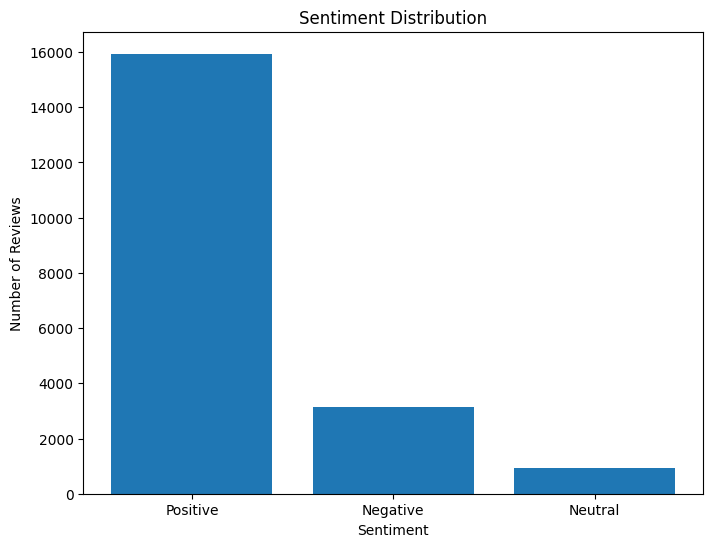

In [ ]:
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from nltk.sentiment import SentimentIntensityAnalyzer  # Correct import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure necessary NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load dataset
dataset_path = "/amazon.csv"
try:
    data = pd.read_csv(dataset_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: File '{dataset_path}' not found.")
    exit()

# Print column names to verify correct naming
print("Dataset Columns:", data.columns)

# Identify the correct column containing text reviews
possible_columns = ['review', 'text', 'comment', 'feedback', 'reviews', 'content']
review_column = None
for col in data.columns:
    if col.lower() in possible_columns:
        review_column = col
        break

if not review_column:
    print("Error: No suitable review text column found in dataset.")
    exit()

print(f"Using column '{review_column}' for text analysis.")

# Check for missing values
data.dropna(subset=[review_column], inplace=True)

def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

# Apply preprocessing
data['cleaned_text'] = data[review_column].apply(preprocess_text)

# Lexicon-Based Sentiment Analysis
def analyze_sentiment(text):
    if not text.strip():
        return "Neutral"
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return "Positive"
    elif sentiment_score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

data['sentiment_vader'] = data['cleaned_text'].apply(analyze_sentiment)
data['sentiment_textblob'] = data['cleaned_text'].apply(lambda x: "Positive" if TextBlob(x).sentiment.polarity > 0 else ("Negative" if TextBlob(x).sentiment.polarity < 0 else "Neutral"))
print("Lexicon-Based Sentiment Analysis Results:")
print(data[[review_column, 'sentiment_vader', 'sentiment_textblob']].head())

# Machine Learning-Based Sentiment Analysis
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_text'])
y = data['sentiment_vader'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Logistic Regression Sentiment Analysis:")
print(classification_report(y_test, y_pred_log))

# Naïve Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naïve Bayes Sentiment Analysis:")
print(classification_report(y_test, y_pred_nb))

# Deep Learning Model (LSTM)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['cleaned_text'])
X_seq = tokenizer.texts_to_sequences(data['cleaned_text'])
X_pad = pad_sequences(X_seq, maxlen=200)

X_train_pad, X_test_pad, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"LSTM Model Accuracy: {accuracy:.4f}")

# Save processed data
data.to_csv("processed_amazon.csv", index=False)
print("Processed data saved to 'processed_amazon.csv'")
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ... (Your existing code)

# Visualization: Word Cloud
if not data['cleaned_text'].empty:
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data['cleaned_text']))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
else:
    print("No text data available for word cloud visualization.")

# Visualization: Sentiment Distribution
sentiment_counts = data['sentiment_vader'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()



